## Project Abstract

Cats’ vs dogs object detection is one of the projects which can be done under computer vision. The main motto of this data set is to process the images of cats and dogs and predict their labels as cat or dog using few machine learning functional metrics (RMSE and MSE). These types of object detection problems come under computer vision. In this phase we will try to classify the images to predict whether it is cat or dog. Humans can easily say that the given image is a cat or a dog but for a machine it is difficult to predict it. This data set was firstly used in a Kaggle competition held in 2013. There are about 13,000 images of varying shapes and aspect ratios. They are all RGB pictures and have bounding box organizes put away in a .csv record.
For this object classification and detection, we will be using convolution Neural Network (CNN) and using machine learning algorithms we will be able to classify these images for achieving this we will be using logistic regression to classify the images on top of that we will be implementing stochastic gradient descent and an adaptive learning rate. As we are using bounding boxes, the best way to predict bounding boxes is to use linear regression and again on top of that we will use gradient descent. We will be using SKLearn’s and Pytorch models to implement all the above functionalities. 


## Project Description

The goal of this project is to create object identification pipelines for cats and dogs images using Python, OpenCV, SKLearn, and PyTorch. We import image catalog data, run exploratory data analysis on it, and derive metrics and baseline models from it. To make a detector, we'll need to preprocess the pictures so that they're all of the same form, then take their RGB intensity values and flatten them to from a 3D array to a 2D array. Then predict labels and bounding boxes, we'll pass this array through a linear classifier and a linear regressor.Build an image classification SKLearn model and a regression SKLearn model. Create a Logistic Regression model from scratch and extend the CXE loss function to CXE + MSE. Create a PyTorch baseline pipeline for object classification and localization. 

Build a specific object classifier and detector using a convolutional neural network network.

### Data Description & Analysis

###Cats vs Dogs Detector (CaDoD)

**Traning Data** - This contains about images of cats and dogs in jpg format. The images are of various resolution and are RGB scale. 

**Test Data** - Test data contains images of cats and dogs.


####Data preprocessing
- The data has to be rescaled to a specific aspect ratio.
- Shuffling the train set can be benificial option.
- Rescaled training data is saved for easy load in the future.

The image archive `cadod.tar.gz` is a subset [Open Images V6](https://storage.googleapis.com/openimages/web/download.html). It contains a total of 12,966 images of dogs and cats.


Image bounding boxes are stored in the csv file `cadod.csv`. The following describes whats contained inside the csv.

* ImageID: the image this box lives in.
* Source: indicates how the box was made:
    * xclick are manually drawn boxes using the method presented in [1], were the annotators click on the four extreme points of the object. In V6 we release the actual 4 extreme points for all xclick boxes in train (13M), see below.
    * activemil are boxes produced using an enhanced version of the method [2]. These are human verified to be accurate at IoU>0.7.
* LabelName: the MID of the object class this box belongs to.
* Confidence: a dummy value, always 1.
* XMin, XMax, YMin, YMax: coordinates of the box, in normalized image coordinates. XMin is in [0,1], where 0 is the leftmost pixel, and 1 is the rightmost pixel in the image. Y coordinates go from the top pixel (0) to the bottom pixel (1).
* XClick1X, XClick2X, XClick3X, XClick4X, XClick1Y, XClick2Y, XClick3Y, XClick4Y: normalized image coordinates (as XMin, etc.) of the four extreme points of the object that produced the box using [1] in the case of xclick boxes. Dummy values of -1 in the case of activemil boxes.

The attributes have the following definitions:

* IsOccluded: Indicates that the object is occluded by another object in the image.
* IsTruncated: Indicates that the object extends beyond the boundary of the image.
* IsGroupOf: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people). We asked annotators to use this tag for cases with more than 5 instances which are heavily occluding each other and are physically touching.
* IsDepiction: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
* IsInside: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building).
For each of them, value 1 indicates present, 0 not present, and -1 unknown.

In [1]:
from collections import Counter
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
import tarfile
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive,files
drive.mount('/content/gdrive')

# Google collab dir: Account: kikarand@iu.edu
DATA_DIR="gdrive/MyDrive/data/"

extract_path = 'images/'
image_file_name = 'cadod.tar.gz'
bounding_box_file_name = 'cadod.csv'


image_path = os.path.join(DATA_DIR, image_file_name)
bounding_box_path = os.path.join(DATA_DIR, bounding_box_file_name)


Mounted at /content/gdrive


In [2]:
extract_path = 'images/'
image_file_name = 'cadod.tar.gz'
bounding_box_file_name = 'cadod.csv'


image_path = os.path.join(DATA_DIR, image_file_name)
bounding_box_path = os.path.join(DATA_DIR, bounding_box_file_name)
resize_path = os.path.join(extract_path, "resized")

In [3]:
!mkdir -p $resize_path

# Import Data

### Unarchive data

In [4]:
def extract_tar(file, path):
    """
    function to extract tar.gz files to specified location
    
    Args:
        file (str): path where the file is located
        path (str): path where you want to extract
    """
    with tarfile.open(file) as tar:
        files_extracted = 0
        for member in tqdm(tar.getmembers()):
            if os.path.isfile(path + member.name[1:]):
                continue
            else:
                tar.extract(member, path)
                files_extracted += 1
        tar.close()
        if files_extracted < 3:
            print('Files already exist')

In [5]:
extract_tar(image_path, extract_path)

  0%|          | 0/25936 [00:00<?, ?it/s]

### Load bounding box meta data

In [6]:
df = pd.read_csv(bounding_box_path)

In [7]:
df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000b9fcba019d36,xclick,/m/0bt9lr,1,0.165000,0.903750,0.268333,0.998333,1,1,...,0,0,0.636250,0.903750,0.748750,0.165000,0.268333,0.506667,0.998333,0.661667
1,0000cb13febe0138,xclick,/m/0bt9lr,1,0.000000,0.651875,0.000000,0.999062,1,1,...,0,0,0.312500,0.000000,0.317500,0.651875,0.000000,0.410882,0.999062,0.999062
2,0005a9520eb22c19,xclick,/m/0bt9lr,1,0.094167,0.611667,0.055626,0.998736,1,1,...,0,0,0.487500,0.611667,0.243333,0.094167,0.055626,0.226296,0.998736,0.305942
3,0006303f02219b07,xclick,/m/0bt9lr,1,0.000000,0.999219,0.000000,0.998824,1,1,...,0,0,0.508594,0.999219,0.000000,0.478906,0.000000,0.375294,0.720000,0.998824
4,00064d23bf997652,xclick,/m/0bt9lr,1,0.240938,0.906183,0.000000,0.694286,0,0,...,0,0,0.678038,0.906183,0.240938,0.522388,0.000000,0.370000,0.424286,0.694286


# ***Phase 1***

# Exploratory Data Analysis

## Statistics

In [12]:
print(f"There are a total of {len(glob.glob1(extract_path, '*.jpg'))} images")

There are a total of 12966 images


In [13]:
print(f"The total size is {os.path.getsize(extract_path)/1000} MB")

The total size is 1105.92 MB


In [14]:
df.shape

(12966, 21)

Replace `LabelName` with human readable labels

In [15]:
df.LabelName.replace({'/m/01yrx':'cat', '/m/0bt9lr':'dog'}, inplace=True)

In [16]:
df.LabelName.value_counts()

dog    6855
cat    6111
Name: LabelName, dtype: int64

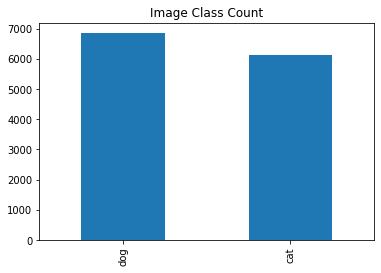

In [17]:
df.LabelName.value_counts().plot(kind='bar')
plt.title('Image Class Count')
plt.show()

In [18]:
df.describe()

,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
count,12966.0,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000
mean,1.0,0.099437,0.901750,0.088877,0.945022,0.464754,0.738470,0.013651,0.045427,0.001157,0.390356,0.424582,0.494143,0.506689,0.275434,0.447448,0.641749,0.582910
std,0.0,0.113023,0.111468,0.097345,0.081500,0.499239,0.440011,0.118019,0.209354,0.040229,0.358313,0.441751,0.405033,0.462281,0.415511,0.401580,0.448054,0.403454
min,1.0,0.000000,0.408125,0.000000,0.451389,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.0,0.000000,0.830625,0.000000,0.910000,0.000000,0.000000,0.000000,0.000000,0.000000,0.221292,0.096875,0.285071,0.130000,0.024323,0.218333,0.405816,0.400000
50%,1.0,0.061250,0.941682,0.059695,0.996875,0.000000,1.000000,0.000000,0.000000,0.000000,0.435625,0.415625,0.531919,0.623437,0.146319,0.480838,0.825000,0.646667
75%,1.0,0.167500,0.998889,0.144853,0.999062,1.000000,1.000000,0.000000,0.000000,0.000000,0.609995,0.820000,0.787500,0.917529,0.561323,0.729069,0.998042,0.882500
max,1.0,0.592500,1.000000,0.587088,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999375,0.999375,1.000000,0.999375,0.999375,0.999375,1.000000,0.999375


## Sample of Images

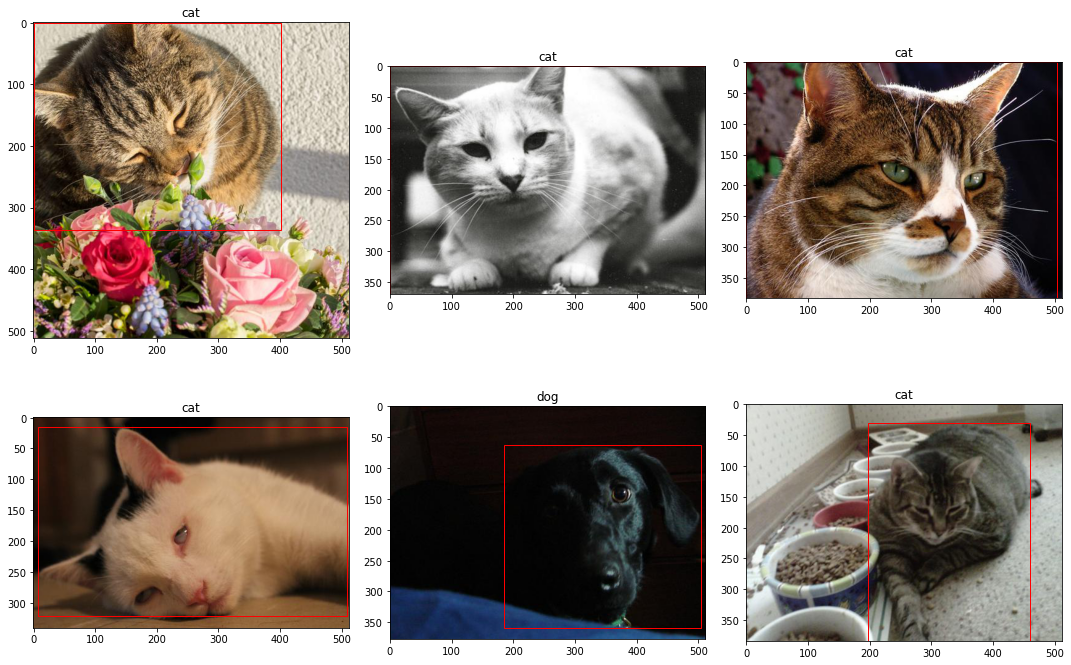

In [19]:
# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):
    img = mpimg.imread(extract_path + df.ImageID.values[j] + '.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j,4:8]
    ax[i].imshow(img)
    ax[i].set_title(df.LabelName[j])
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

## Image shapes and sizes

Go through all images and record the shape of the image in pixels and the memory size

In [20]:
img_shape = []
img_size = np.zeros((df.shape[0], 1))

for i,f in enumerate(tqdm(glob.glob1(extract_path, '*.jpg'))):
    file = extract_path+'/'+f
    img = Image.open(file)
    img_shape.append(f"{img.size[0]}x{img.size[1]}")
    img_size[i] += os.path.getsize(file)

  0%|          | 0/12966 [00:00<?, ?it/s]

Count all the different image shapes

In [21]:
img_shape_count = Counter(img_shape)

In [22]:
# create a dataframe for image shapes
img_df = pd.DataFrame(set(img_shape_count.items()), columns=['img_shape','img_count'])

In [23]:
img_df.shape

(594, 2)

There are a ton of different image shapes. Let's narrow this down by getting a sum of any image shape that has a cout less than 100 and put that in a category called `other`

In [24]:
img_df = img_df.append({'img_shape': 'other','img_count': img_df[img_df.img_count < 100].img_count.sum()}, 
                       ignore_index=True)

Drop all image shapes

In [25]:
img_df = img_df[img_df.img_count >= 100]

Check if the count sum matches the number of images

In [26]:
img_df.img_count.sum() == df.shape[0]

True

Plot

## TODO plot aspect ratio

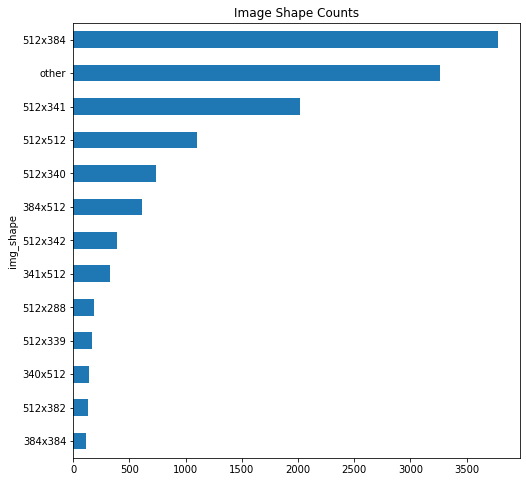

In [27]:
img_df.sort_values('img_count', inplace=True)
img_df.plot(x='img_shape', y='img_count', kind='barh', figsize=(8,8), legend=False)
plt.title('Image Shape Counts')
plt.show()

In [28]:
# convert to megabytes
img_size = img_size / 1000

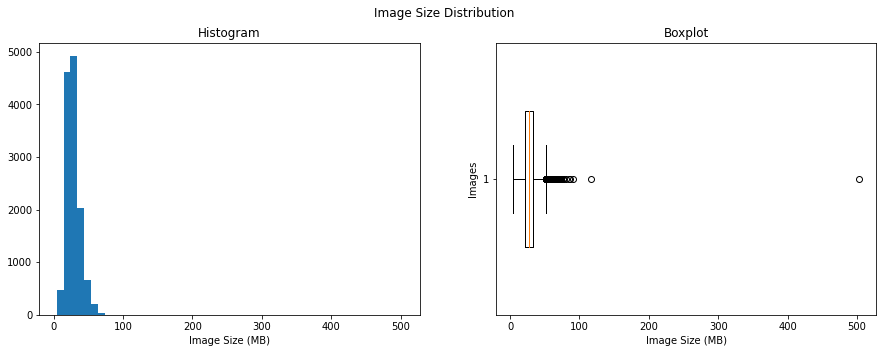

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Image Size Distribution')
ax[0].hist(img_size, bins=50)
ax[0].set_title('Histogram')
ax[0].set_xlabel('Image Size (MB)')
ax[1].boxplot(img_size, vert=False, widths=0.5)
ax[1].set_title('Boxplot')
ax[1].set_xlabel('Image Size (MB)')
ax[1].set_ylabel('Images')
plt.show()

# Preprocess

## Rescale the images

In [30]:
import os
import glob

files = glob.glob(f'{resize_path}/*')
for f in files:
    os.remove(f)

In [31]:
%%time
# resize image and save, convert to numpy

img_arr = np.zeros((df.shape[0],32*32*3)) # initialize np.array

for i, f in enumerate(tqdm(df.ImageID)):
    img = Image.open(extract_path+f+'.jpg')
    img_resized = img.resize((32,32))
    img_resized.save(os.path.join(resize_path,f"{f}.jpg"), "JPEG", optimize=True)
    img_arr[i] = np.asarray(img_resized, dtype=np.uint8).flatten()

  0%|          | 0/12966 [00:00<?, ?it/s]

CPU times: user 1min, sys: 1.87 s, total: 1min 1s
Wall time: 1min 3s


In [32]:
print(len(img_arr[0]))

3072


Plot the resized and filtered images

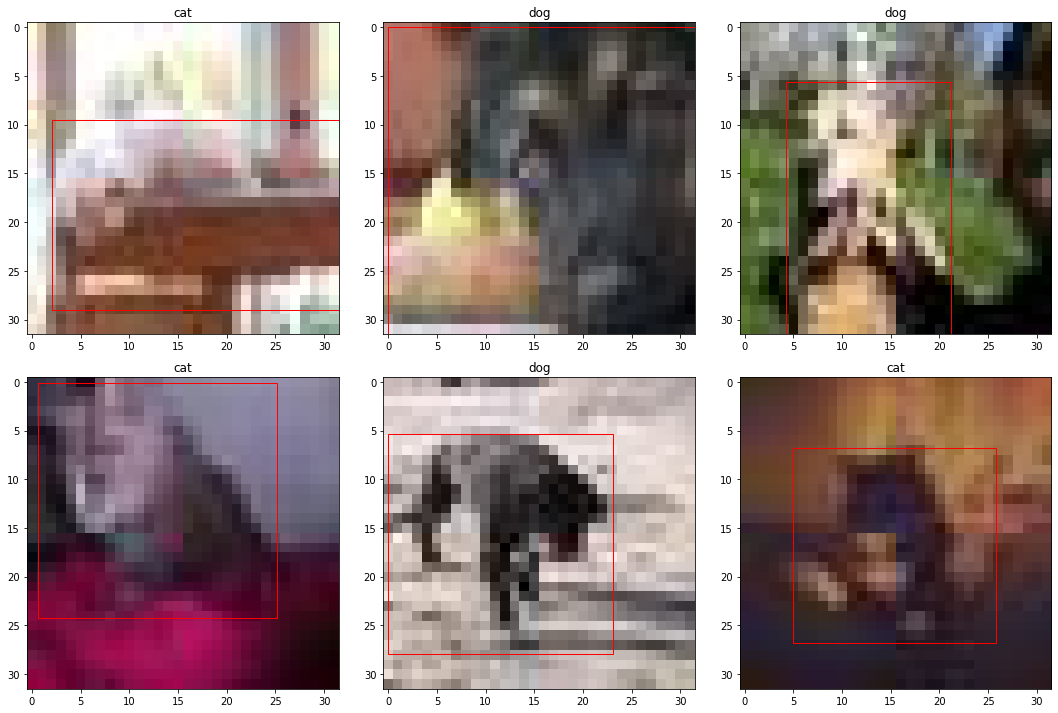

In [33]:
# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):
    img = mpimg.imread(f"{resize_path}/"+df.ImageID.values[j]+'.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j,4:8]
    ax[i].imshow(img)
    ax[i].set_title(df.iloc[j,2])
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

In [34]:
# encode labels
df['Label'] = (df.LabelName == 'dog').astype(np.uint8)

### Comparing Images Before and After

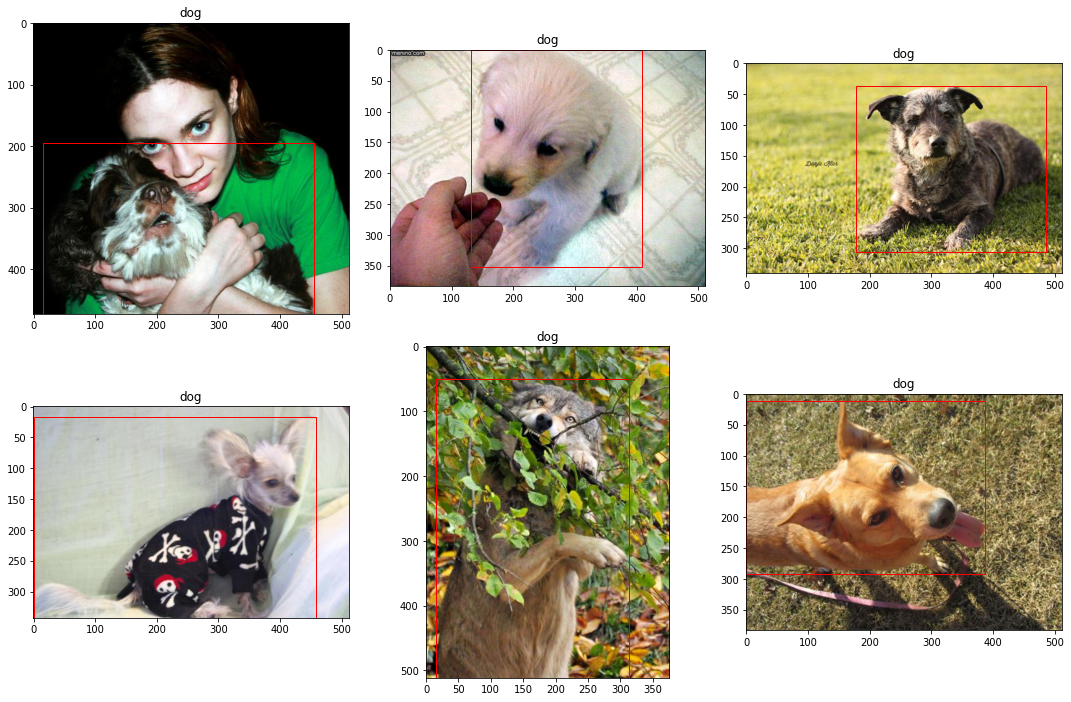

In [35]:
# plot first 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(df.index[5584:5590].to_numpy()):
    img = mpimg.imread(extract_path + df.ImageID.values[j] + '.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j,4:8]
    ax[i].imshow(img)
    ax[i].set_title(df.LabelName[j])
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

## Checkpoint and Save data

In [36]:
mkdir -p \data

In [37]:
np.save('data/img.npy', img_arr.astype(np.uint8))
np.save('data/y_label.npy', df.Label.values)
np.save('data/y_bbox.npy', df[['XMin', 'YMin', 'XMax', 'YMax']].values.astype(np.float32))

# Baseline in SKLearn

## Load data

In [38]:
X = np.load('data/img.npy', allow_pickle=True)
y_label = np.load('data/y_label.npy', allow_pickle=True)
y_bbox = np.load('data/y_bbox.npy', allow_pickle=True)

In [39]:
idx_to_label = {1:'dog', 0:'cat'} # encoder

Double check that it loaded correctly

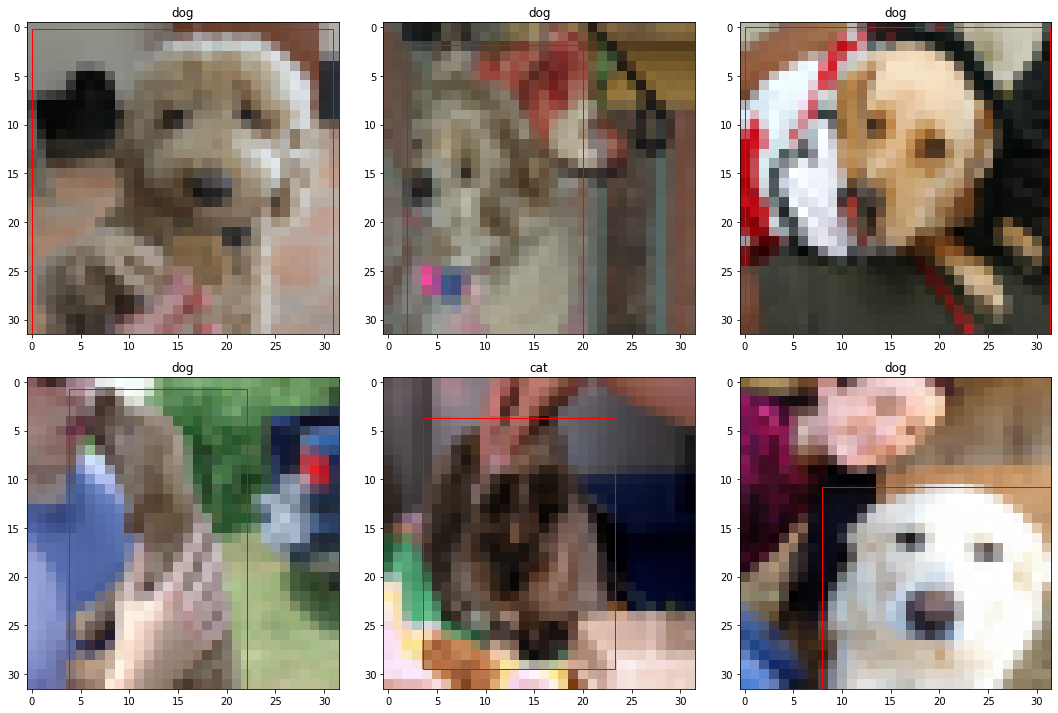

In [40]:
# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(X.shape[0], size=6, replace=False)):
    coords = y_bbox[j] * 32
    ax[i].imshow(X[j].reshape(32,32,3))
    ax[i].set_title(idx_to_label[y_label[j]])
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]), 
                                  coords[2]-coords[0], coords[3]-coords[1], 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

## Classification

### Split data

Create training and testing sets

In [41]:
X_train, X_test, y_train, y_test_label = train_test_split(X, y_label, test_size=0.01, random_state=27)

### Train

I'm choosing `SGDClassifier` because the data is large and I want to be able to perform stochastic gradient descent and also its ability to early stop. With this many parameters, a model can easily overfit so it's important to try and find the point of where it begins to overfit and stop for optimal results.

In [42]:
%%time
model = SGDClassifier(loss='log', n_jobs=-1, random_state=27, learning_rate='adaptive', eta0=1e-10, 
                      early_stopping=True, validation_fraction=0.1, n_iter_no_change=3)
# 0.2 validation TODO
model.fit(X_train, y_train)

CPU times: user 924 ms, sys: 416 ms, total: 1.34 s
Wall time: 930 ms


In [43]:
model.n_iter_

4

Did it stop too early? Let's retrain with a few more iterations to see. Note that `SGDClassifier` has a parameter called `validation_fraction` which splits a validation set from the training data to determine when it stops.

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=27)

In [45]:
model2 = SGDClassifier(loss='log', n_jobs=-1, random_state=27, learning_rate='adaptive', eta0=1e-10)

epochs = 30

train_acc = np.zeros(epochs)
valid_acc = np.zeros(epochs)
for i in tqdm(range(epochs)):
    model2.partial_fit(X_train, y_train, np.unique(y_train))
    
    #log
    train_acc[i] += np.round(accuracy_score(y_train, model2.predict(X_train)),3)
    valid_acc[i] += np.round(accuracy_score(y_valid, model2.predict(X_valid)),3)

  0%|          | 0/30 [00:00<?, ?it/s]

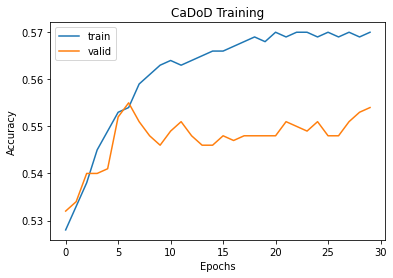

In [46]:
plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.title('CaDoD Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [47]:
del model2

### Evaluation

In [48]:
expLog = pd.DataFrame(columns=["exp_name", 
                               "Train Acc", 
                               "Valid Acc",
                               "Test  Acc",
                               "Train MSE", 
                               "Valid MSE",
                               "Test  MSE",
                              ])

In [49]:
exp_name = f"Baseline: Linear Model"
expLog.loc[0,:4] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model.predict(X_train)), 
                accuracy_score(y_valid, model.predict(X_valid)),
                accuracy_score(y_test_label, model.predict(X_test))],3))

In [50]:
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train MSE,Valid MSE,Test MSE
0,Baseline: Linear Model,0.565,0.557,0.615,NaN,NaN,NaN


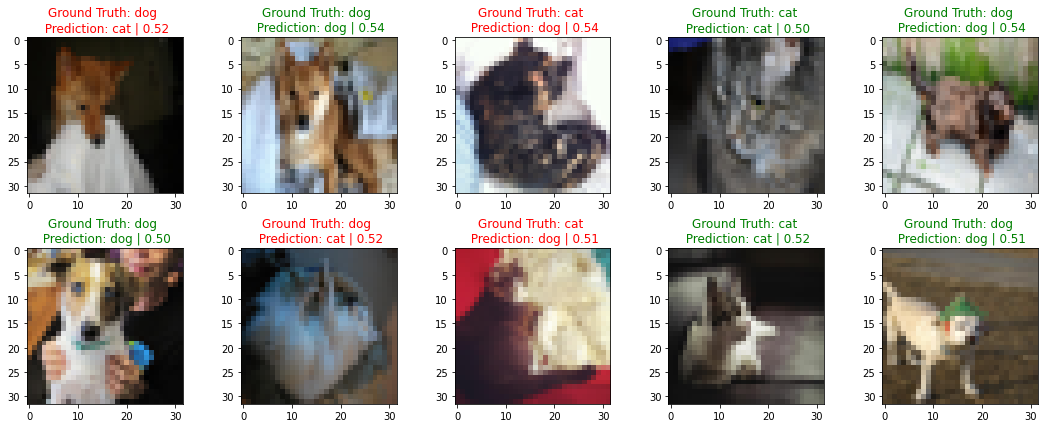

In [51]:
y_pred_label = model.predict(X_test)
y_pred_label_proba = model.predict_proba(X_test)

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False,figsize=(15,6))
ax = ax.flatten()

for i in range(10):
    img = X_test[i].reshape(32,32,3)
    ax[i].imshow(img)
    ax[i].set_title("Ground Truth: {0} \n Prediction: {1} | {2:.2f}".format(idx_to_label[y_test_label[i]],
                                                                   idx_to_label[y_pred_label[i]],
                                                                   y_pred_label_proba[i][y_pred_label[i]]),
                   color=("green" if y_pred_label[i]==y_test_label[i] else "red"))

plt.tight_layout()
plt.show()

In [52]:
# imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
from time import time
from scipy import stats
import json

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

## Regression

### Split data

In [53]:
d1 = []
for i1 in img_arr:
    d1.append(i1)
temp_image_data=[]
for i in range(0,len(df)):
    temp_image_data.append(pd.Series(data = d1).iloc[i])

In [54]:
len(temp_image_data)
len(img_arr[0])

3072

In [55]:
X_train, X_test, y_train, y_test = train_test_split(np.array(temp_image_data), y_bbox, test_size=0.01, random_state=27)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=27)

### Train

In [56]:
%%time

from sklearn.linear_model import LinearRegression
# TODO closed loop solution, could use Lasso Ridge
model = LinearRegression() #fill in 
model.fit(X_train, y_train)

# might take a few minutes to train
#CPU times: user 1h 26min 40s, sys: 5min 53s, total: 1h 32min 34s
#Wall time: 17min 24s

CPU times: user 35.9 s, sys: 1.11 s, total: 37 s
Wall time: 19.3 s


### Baseline Linear regression with lasso and ridge

### Evaluation

In [57]:
expLog.iloc[0,4:] = list(np.round([mean_squared_error(y_train, model.predict(X_train)), 
          mean_squared_error(y_valid, model.predict(X_valid)), 
          mean_squared_error(y_test, model.predict(X_test))],3))

expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train MSE,Valid MSE,Test MSE
0,Baseline: Linear Model,0.565,0.557,0.615,0.007,0.015,0.015


In [58]:
# The below code is refered from Hw5
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
np.random.seed(42)

estimators = [('ridge', Ridge()),
              ('lasso', Lasso())]

best_score = []
best_param = []
for estimator in estimators:
    params = {estimator[0]+'__alpha':[.01, .05, .1, .5, 1, 5]}
    # set up the pipeline using the standard scaler and estimator
    # and grid search with pipeline, params, 
    # and correct scoring parameter (scoring parameter has to be a utility- where bigger is better 
    # such as neg_mean_squared_error, explained_variance etc. )
    # for more information see the following - 
    #     https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    # Please use neg_mean_squared_error here.
    #==================================================#
    #               Your code starts here              #
    #==================================================#
 
    # TODO - change above to
    pipe = Pipeline([('scalar', StandardScaler()), estimator])
    gs = GridSearchCV(pipe, params, scoring='neg_mean_squared_error',cv=5)
    #==================================================#
    #               Your code ends here                #
    #==================================================#
    
    gs.fit(X_train, y_train)
    best_score.append(gs.best_score_)
    best_param.append(gs.best_params_)
best_idx = np.argmax(best_score)
print('Best model is:', estimators[best_idx][0], 'with parameter', best_param[best_idx])

Best model is: lasso with parameter {'lasso__alpha': 0.01}


In [59]:
list(best_param[best_idx].values())[0]

0.01

In [60]:
#estimator = estimators[best_idx][0], list(best_param[best_idx].values())[0])
estimator = [Ridge, Lasso][best_idx]
param = list(gs.best_params_.values())[0]
print (param)
# set up the pipeline using the best estimator
pipe = Pipeline([('scalar', StandardScaler()), ('estimator', estimator(alpha=param))])
pipe.fit(X_train, y_train)

0.01


Pipeline(steps=[('scalar', StandardScaler()), ('estimator', Lasso(alpha=0.01))])

In [61]:
exp_name = f"Linear Regression(best regularization and alpha)"
expLog.loc[1,:4] = [f"{exp_name}"] +list(np.round([0, 
          0, 
          0],3))
expLog.loc[1,4:] = list(np.round([mean_squared_error(y_train, pipe.predict(X_train)), 
          mean_squared_error(y_valid, pipe.predict(X_valid)), 
          mean_squared_error(y_test, pipe.predict(X_test))],3))
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train MSE,Valid MSE,Test MSE
0,Baseline: Linear Model,0.565,0.557,0.615,0.007,0.015,0.015
1,Linear Regression(best regularization and alpha),0,0,0,0.01,0.011,0.009


### Modelling Pipelines
### Baseline

In [62]:
# Below code is refered from HW13, Hw7,Hw2
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
X = np.load('data/img.npy', allow_pickle=True)
y_label = np.load('data/y_label.npy', allow_pickle=True)
y_bbox = np.load('data/y_bbox.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'}
X_train_class, X_test_class, y_train_label, y_test_label = train_test_split(X, y_label, stratify=y_label, shuffle=True, test_size=0.50, random_state=27)
np.random.seed(42)
X = X.astype(np.float32) / 255.
y_label=y_label.astype(int)

X_train_class, X_test_class, y_train_label, y_test_label = train_test_split(X, y_label, stratify=y_label, shuffle=True, test_size=0.20, random_state=27)

X_train_full = X_train_class
y_train_full = y_train_label
X_test_full = X_test_class
y_test_full = y_test_label

X_train, _, y_train, _ = train_test_split(X_train_class, y_train_label, stratify=y_train_label, train_size=0.1, random_state=42)

X_test, _, y_test, _ = train_test_split(X_test_class, y_test_label, stratify=y_test_label, train_size=0.1, random_state=42)

In [63]:
# use full pipeline above to build full pipeline with predictor
np.random.seed(42)
full_pipeline_with_predictor = Pipeline([
        ("linear", LogisticRegression(random_state=42))
    ])

full_pipeline_with_predictor.fit(X_train, y_train)

Pipeline(steps=[('linear', LogisticRegression(random_state=42))])

In [64]:
start = time()
full_pipeline_with_predictor.fit(X_train, y_train)
np.random.seed(42)

# Set up cross validation scores 
# Use ShuffleSplit() with 30 splits, 30% test_size 
# and a random seed of 0
#==================================================#
#               Your code starts here              #
#==================================================#
cv3Splits = ShuffleSplit(n_splits=3, random_state=0, test_size=0.30, train_size=None)
logit_scores = cross_val_score(full_pipeline_with_predictor, X_train, y_train, cv=cv3Splits)     
#==================================================#
#               Your code ends here                #
#               Please don't add code below here   #
#==================================================#
logit_score_train = logit_scores.mean()
train_time = np.round(time() - start, 4)

# Time and score test predictions
start = time()
logit_score_test  = full_pipeline_with_predictor.score(X_test, y_test)
test_time = np.round(time() - start, 4)

In [65]:
results = pd.DataFrame(columns=["Expname", "Train accuracy", "Test Accuracy"])
results.loc[0] = ["Baseline", np.round(100*logit_score_train,1), np.round(np.round(100*logit_score_test,1),3)]
results

,Expname,Train accuracy,Test Accuracy
0,Baseline,54.0,55.2


In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# A Function to execute the grid search and record the results.
def ConductGridSearch(X_train, y_train, X_test, y_test, i=0, prefix='', n_jobs=-1,verbose=1):
    # Create a list of classifiers for our grid search experiment
    classifiers = [
        ('Logistic Regression', LogisticRegression(random_state=42)),
        ('K-Nearest Neighbors', KNeighborsClassifier()),
        ('Naive Bayes', GaussianNB()),
        ('Support Vector', SVC(random_state=42)),
        ('Stochastic GD', SGDClassifier(loss='log',
                                        penalty='l2',
                                        early_stopping=True,
                                        max_iter=10000, tol=1e-5,
                                        random_state=42)),
        
    ]

    # Arrange grid search parameters for each classifier
    params_grid = {
        'Logistic Regression': {
            'penalty': ('l1', 'l2'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'C': (10, 1, 0.1, 0.01),
        },
        'K-Nearest Neighbors': {
            'n_neighbors': (3, 5, 7, 8, 11),
            'p': (1,2),
        },
        'Naive Bayes': {},
        'Support Vector' : {
            'kernel': ('rbf', 'poly'),     
            'degree': (1, 2, 3, 4, 5),
            'C': (10, 1, 0.1, 0.01),
        },
        'Stochastic GD': {
            'tol': (0.0001, 0.0000001), 
            'alpha': (0.1, 0.001, 0.0001), 
        }
    }
    
    for (name, classifier) in classifiers:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
        ("predictor", classifier)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring='accuracy', cv=5, 
                                   n_jobs=n_jobs, verbose=verbose)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = np.round(100*grid_search.best_score_,1)

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time() - start, 4)
        
# #         plt.barh(['Age', 'Parch', 'SibSp','Fare','x0_C' ,'x0_Q' ,'x0_S' ,'x1_female', 'x1_male' ,'x2_1' ,'x2_2', 'x2_3'], grid_search.best_estimator_.named_steps["predictor"].feature_importances_)
# #         plt.show()
#         features = ['Age', 'Parch', 'SibSp','Fare','x0_C' ,'x0_Q' ,'x0_S' ,'x1_female', 'x1_male' ,'x2_1' ,'x2_2', 'x2_3']
#         importances = grid_search.best_estimator_.named_steps["predictor"].feature_importances_
#         indices = np.argsort(importances)

#         plt.title('Feature Importances')
#         plt.barh(range(len(indices)), importances[indices], color='b', align='center')
#         plt.yticks(range(len(indices)), [features[i] for i in indices])
#         plt.xlabel('Relative Importance')
#         plt.grid()
#         plt.show();
        # Best estimator prediction time
        start = time()
        best_test_accuracy = np.round(100*grid_search.best_estimator_.score(X_test, y_test),1)
        test_time = round(time() - start, 4)

        # Generate 30 training accuracy scores with the best estimator and 30-split CV
        # To calculate the best_train_accuracy use the pct() and mean() methods
        #==================================================#
        #               Your code starts here              #
        #==================================================#
        best_train_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv3Splits)
        best_train_accuracy = np.round(100*best_train_scores.mean(),1)
        #==================================================#
        #               Your code ends here                #
        #               Please don't add code below here   #
        #==================================================#    
       
        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(logit_scores, best_train_scores)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, best_train_accuracy, best_test_accuracy]

In [67]:
ConductGridSearch(X_train, y_train, X_test, y_test, 0, "Best Model:",  n_jobs=-1,verbose=1)

****** START Best Model: Logistic Regression *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	penalty: ('l1', 'l2')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters:
	predictor__C: 0.01
	predictor__penalty: l2
	predictor__tol: 0.0001
****** FINISH Best Model: Logistic Regression  *****

****** START Best Model: K-Nearest Neighbors *****
Parameters:
	n_neighbors: (3, 5, 7, 8, 11)
	p: (1, 2)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:
	predictor__n_neighbors: 11
	predictor__p: 2
****** FINISH Best Model: K-Nearest Neighbors  *****

****** START Best Model: Naive Bayes *****
Parameters:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters:
****** FINISH Best Model: Naive Bayes  *****

****** START Best Model: Support Vector *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	degree: (1, 2, 3, 4, 5)
	kernel: ('rbf', 'poly')
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Para

In [68]:
results

,Expname,Train accuracy,Test Accuracy
0,Baseline,54.0,55.2
1,Best Model:Logistic Regression,56.9,53.3
2,Best Model:K-Nearest Neighbors,53.0,56.0
3,Best Model:Naive Bayes,54.0,55.2
4,Best Model:Support Vector,56.1,52.9
5,Best Model:Stochastic GD,52.9,57.9


# Results / Discussion

Cats and Dogs Classification is a popular ML problem, which can be solved using various techniques. We performed algorithms like logistic regression, KNN, Naive Baye’s, Support Vector, Stochastic Gradient Descent, to find out how well these algorithms can predict class for the cat and dog image set. 
- Among all the models Gradient Descent proved to be better, with accuracy of 57.9 and the runner up is KNN. 
- We have also implemented Baseline linear regression along with Baseline LR with Lasso and Ridge(with alpha and best parameters). Lasso and Ridge metrics performed better.


# Challenges :

The main challenges was to work with a huge dataset.
Hence we decreased image size from 128x128 to 32x32.


# Conclusion

In phase 1, we have focused on the SKLearn Baseline models for logistic regression, SGDClassifier to classify the images into cats and dogs and Linear regression for making the bounding boxes around the cats and dogs inside the image.
Well, Test Accuracy alone can’t tell how good an algorithm predicts the classes in general on various data set. We hope to experiment more by implementing homegrown logistic regression model and CNN in the next phase. 


# ***Phase 2***

# Homegrown implementation

Implement a Homegrown Logistic Regression model. Extend the loss function from CXE to CXE + MSE, i.e., make it a complex multitask loss function the resulting model   predicts the class and bounding box coordinates at the same time.

In [ ]:
# Below lines of code is taken from HW7 and labs

In [69]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(np.array(temp_image_data), y_bbox, test_size=0.01, random_state=27)
X_train_r, X_valid_r, y_train_r, y_valid_r = train_test_split(X_train_r, y_train_r, test_size=0.1, random_state=27)

In [70]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(np.array(temp_image_data), y_label, test_size=0.01, random_state=27)
X_train_c, X_valid_c, y_train_c, y_valid_c = train_test_split(X_train_c, y_train_c, test_size=0.1, random_state=27)

In [71]:
# scale data for classification
np.random.seed(42)
if np.max(X_train_c) > 4.:
    X_train_c = X_train_c.astype(np.float32) / 255.
if np.max(X_valid_c) > 4.:
    X_valid_c = X_valid_c.astype(np.float32) / 255.
y_train_c=y_train_c.astype(int)
y_valid_c=y_valid_c.astype(int)

In [72]:
# scale data for reg
np.random.seed(42)
if np.max(X_train_r) > 4.:
    X_train_r = X_train_r.astype(np.float32) / 255.
if np.max(X_valid_r) > 4.:
    X_valid_r = X_valid_r.astype(np.float32) / 255.
y_train_r=y_train_r.astype(int)
y_valid_r=y_valid_r.astype(int)
main_loss = [0 for i in range(1000)]
main_loss_1 = [0 for i in range(1000)]

In [73]:
class LogisticRegressionHomegrown1(object):
    
    def __init__(self):
        """
        Constructor for the homgrown Logistic Regression
        
        Args:
            None
        
        Return:
            None
        """
        self.coef_ = None       # weight vector
        self.intercept_ = None  # bias term
        self._theta = None      # augmented weight vector, i.e., bias + weights
                                # this allows to treat all decision variables homogeneously
        self.history = {"cxe+mse": [], 
                        "mse": [], 
                        "cxe":[], 
                        "val_cxe+mse": [],
                       "val_cxe":[],
                       "val_mse":[]}
        
    def _grad(self, X, y):
        """
        Calculates the gradient of the Logistic Regression 
        objective function

        Args:
            X(ndarray):    train objects
            y(ndarray):    answers for train objects
            
        Return:
            grad(ndarray): gradient
        """
        # number of training examples
        n = X.shape[0]
        
        # get scores for each class and example
        # 2D matrix
        scores = self._predict_raw(X)
        gradient = np.dot(X.T, scores) / n
        
        return gradient
    
    def _gd(self, X, y, max_iter, alpha, X_val, y_val):
        """
        Runs Full GD and logs error, weigths, gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
            
        Return:
            None
        """
        for i in range(max_iter):
            
            metrics = self.score(X, y)
            metrics["cxe+mse"] = metrics["cxe+mse"]+np.round(np.mean(main_loss[i]),decimals=10)
            metrics["cxe"] =  metrics["cxe"]+np.round(np.mean(main_loss[i]),decimals=10)
            print("Epoch: ",i+1,"- ", metrics)
            self.history["cxe+mse"].append(metrics["cxe+mse"])
            self.history["cxe"].append(metrics["cxe"])
            self.history["mse"].append(metrics["mse"])
            
            if X_val is not None:
                metrics_val = self.score(X_val, y_val)
                self.history["val_cxe+mse"].append(metrics_val["cxe+mse"])
                self.history["val_cxe"].append(metrics_val["cxe"])
                self.history["val_mse"].append(metrics_val["mse"])

            # calculate gradient
            grad = self._grad(X, y)
            
            # do gradient step
            self._theta -= alpha * grad
    
    def fit(self, X, y, max_iter=1000, alpha=0.05, val_data=None):
        """
        Public API to fit Logistic regression model
        
        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
            
        Return:
            None
        """
        # Augment the data with the bias term.
        # So we can treat the the input variables and the bias term homogeneously 
        # from a vectorization perspective
        X = np.c_[np.ones(X.shape[0]), X]
        if val_data is not None:
            X_val, y_val = val_data
            X_val = np.c_[np.ones(X_val.shape[0]), X_val]
        else:
            X_val = None
            y_val = None
        # initialize if the first step
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1], 4)
        
        # do full gradient descent
        self._gd(X, y, max_iter, alpha, X_val, y_val)
        
        # get final weigths and bias
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        
    def score(self, X, y):
        """
        Computes logloss and accuracy for (X, y)
        
        Args:
            X(ndarray):      objects
            y(ndarray):      answers for objects
            
        Return:
            metrics(dict):   python dictionary which
                             contains two fields: for accuracy 
                             and for objective function
        """
        scores = self._predict_raw(X)
        metrics = {"cxe+mse": np.round(mean_squared_error(y, scores),decimals=10), "cxe": 0,"mse":np.round(mean_squared_error(y, scores),decimals=10)}
        
        return metrics
        
    def _predict_raw(self, X):
        """
        Computes scores for each class and each object in X
        
        Args:
            X(ndarray):      objects
        
        Return:
            scores(ndarray): scores for each class and object
        """
        # check whether X has appended bias feature or not
        if X.shape[1] == len(self._theta):
            scores = np.dot(X, self._theta)
        else:
            scores = np.dot(X, self.coef_) + self.intercept_
        return scores
    
    def predict(self, X):
        """
        Predicts class for each object in X
        
        Args:
            X(ndarray):      objects
        
        Return:
            pred(ndarray):   class for each object
        """
        # get scores for each class
        scores = self._predict_raw(X)
        # choose class with maximum score
        pred = np.argmax(scores, axis=1)
        return pred

In [74]:
class LogisticRegressionHomegrown(object):
    
    def __init__(self):
        """
        Constructor for the homgrown Logistic Regression
        
        Args:
            None
        
        Return:
            None
        """
        self.coef_ = None       # weight vector
        self.intercept_ = None  # bias term
        self._theta = None      # augmented weight vector, i.e., bias + weights
                                # this allows to treat all decision variables homogeneously
        self.history = {"cost": [], 
                        "acc": [], 
                        "val_cost":[], 
                        "val_acc": []}
        
    def _grad(self, X, y):
        """
        Calculates the gradient of the Logistic Regression 
        objective function

        Args:
            X(ndarray):    train objects
            y(ndarray):    answers for train objects
            
        Return:
            grad(ndarray): gradient
        """
        # number of training examples
        n = X.shape[0]
        # get scores for each class and example
        # 2D matrix
        scores = self._predict_raw(X)
        # transform scores to probabilities
        # softmax
        
        probs = 1.0/(1 + np.exp(-scores))
        #probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        # error
        probs[range(n),y] -= 1
        # (1/m)*np.dot(X.T, (scores - y))
        # gradient
        gradient = np.dot(X.T, probs) / n
        return gradient
    
    def _gd(self, X, y, max_iter, alpha, X_val, y_val):
        """
        Runs Full GD and logs error, weigths, gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
            
        Return:
            None
        """
        for i in range(max_iter):
            
            metrics = self.score(X, y)
            print("Epoch: ",i+1,"- ", metrics)
            main_loss[i] = metrics["cost"]
            main_loss_1[i]= metrics["acc"]
            self.history["cost"].append(metrics["cost"])
            self.history["acc"].append(metrics["acc"])
            
            if X_val is not None:
                metrics_val = self.score(X_val, y_val)
                self.history["val_cost"].append(metrics_val["cost"])
                self.history["val_acc"].append(metrics_val["acc"])

            # calculate gradient
            grad = self._grad(X, y)
            
            # do gradient step
            self._theta -= alpha * grad
        print(len(main_loss))
    
    def fit(self, X, y, max_iter=1000, alpha=0.05, val_data=None):
        """
        Public API to fit Logistic regression model
        
        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
            
        Return:
            None
        """
        # Augment the data with the bias term.
        # So we can treat the the input variables and the bias term homogeneously 
        # from a vectorization perspective
        X = np.c_[np.ones(X.shape[0]), X]
        if val_data is not None:
            X_val, y_val = val_data
            X_val = np.c_[np.ones(X_val.shape[0]), X_val]
        else:
            X_val = None
            y_val = None
        # initialize if the first step
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1], len(np.unique(y)))
        
        # do full gradient descent
        self._gd(X, y, max_iter, alpha, X_val, y_val)
        
        # get final weigths and bias
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        
    def score(self, X, y):
        """
        Computes logloss and accuracy for (X, y)
        
        Args:
            X(ndarray):      objects
            y(ndarray):      answers for objects
            
        Return:
            metrics(dict):   python dictionary which
                             contains two fields: for accuracy 
                             and for objective function
        """
        # number of training samples
        n = X.shape[0]
        metrics = {}
        
        # get scores
        scores = self._predict_raw(X)
        
        # trasnform scores to probabilities
        exp_scores = np.exp(scores)
        exp = 2.73
        probs = 1.0/(1 + exp**(-scores))
        
        # logloss per each example
        corect_logprobs = probs[range(n),y]
#         print(corect_logprobs)
        # total mean logloss
        data_loss = np.sum(corect_logprobs) / n
        # predictions
        pred = np.argmax(scores, axis=1)
        # accuracy
        acc = accuracy_score(y, pred)
        loss = 0
        for each in corect_logprobs:
            if (each!=1 and each!=0):
                loss +=y * (-np.log (each))  + (1-y) * (-np.log (1-each))
        
        # final metrics
        metrics = {"acc": acc, "cost": np.round(np.mean(loss),decimals=10)}
        
        return metrics
        
    def _predict_raw(self, X):
        """
        Computes scores for each class and each object in X
        
        Args:
            X(ndarray):      objects
        
        Return:
            scores(ndarray): scores for each class and object
        """
        # check whether X has appended bias feature or not
        if X.shape[1] == len(self._theta):
            scores = np.dot(X, self._theta)
        else:
            scores = np.dot(X, self.coef_) + self.intercept_
        return scores
    
    def predict(self, X):
        """
        Predicts class for each object in X
        
        Args:
            X(ndarray):      objects
        
        Return:
            pred(ndarray):   class for each object
        """
        # get scores for each class
        scores = self._predict_raw(X)
        # choose class with maximum score
        pred = np.argmax(scores, axis=1)
        return pred

In [75]:
import warnings
warnings.filterwarnings('ignore')

# reference - HW05 - Basic linear regression from scratch

class LinearRegressionHomegrown(object):
    
    def __init__(self):
        """
        Constructor for the homgrown Linear Regression
        
        Args:
            None
        
        Return:
            None
        """
        self.coef_reg = None       # weight vector
        self.intercept_reg = None  # bias term
        self.thetaReg = None      # augmented weight vector, i.e., bias + weights
                                # this allows to treat all decision variables homogeneously
        self.history = {"MSE_train": [], 
                        "Reg_train_MSE":[],
                        "val_MSE":[], 
                        "Reg_val_MSE":[]}
            
    def gradient(self, X, y):
      
        # total training examples
        n = X.shape[0]
        
        # scores for each class and examples
        scores = self._predict_raw(X)
        gradient = np.dot(X.T, scores) / n
        
        return gradient
    
    def gradientDescent(self, X_r, y_r, max_iter, alpha, X_val_r, y_val_r):
        """
        Runs Full GD and logs error, weigths, gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
            
        Return:
            None
        """
        for i in range(max_iter):
            
            metrics = self.score(X_r, y_r)
            print("Epoch: ",i+1,"- ", metrics)
            self.history["Reg_train_MSE"].append(metrics["Reg_MSE"])
            
            if X_val_r is not None:
                metrics_val = self.score(X_val_r, y_val_r)
                self.history["Reg_val_MSE"].append(metrics_val["Reg_MSE"])

            # calculate gradient for regression
            gradient = self.gradient(X_r, y_r)

            # do gradient descent step
            self.thetaReg -= alpha * gradient

    
    def fit(self, X_r,y_r, max_iter=1000, alpha=0.05, val_data_r=None):
        """
        Public API to fit Logistic regression model
        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        # Augment the data with the bias term.
        # to treat the the input variables and the bias term homogeneously(vectorization perspective)
        X_r = np.c_[np.ones(X_r.shape[0]), X_r]
        if val_data_r is not None:
            X_val_r, y_val_r = val_data_r
            X_val_r = np.c_[np.ones(X_val_r.shape[0]), X_val_r]
        else:
            X_val_r = None
            y_val_r = None
        # initialize weights
        if self.thetaReg is None:
            self.thetaReg = np.random.rand(X_r.shape[1], 4)
    
        # do full gradient descent
        self.gradientDescent(X_r, y_r, max_iter, alpha, X_val_r, y_val_r)
        
        # get final weigths and bias
        self.intercept_reg = self.thetaReg[0]
        self.coef_reg = self.thetaReg[1:]
        
    def score(self, X_r, y_r):
        # number of training samples
        n1 = X_r.shape[0]
        # get scores
        scores_r = self._predict_raw(X_r)
        pred_r=scores_r
          
        metrics = {"Reg_MSE": np.round(mean_squared_error(y_r, pred_r),decimals=10)}

        return metrics
        
    def _predict_raw(self, X):
        """
        Computes scores for each class and each object in X
        Args:
            X(ndarray):      objects
        
        Return:
            scores(ndarray): scores for each class and object
        """

        # append bias feature if not appended already 
        if X.shape[1] == len(self.thetaReg):
            scores = np.dot(X, self.thetaReg)
        else:
            scores = np.dot(X, self.coef_reg) + self.intercept_reg
        
        return scores
    

In [76]:
model_lr_homegrown = LogisticRegressionHomegrown()
model_lr_homegrown.fit(X_train_c, y_train_c, max_iter=1000, alpha=0.00005,val_data=[X_valid_c,y_valid_c])

Epoch:  1 -  {'acc': 0.5335006925207756, 'cost': 4.7586433006}
Epoch:  2 -  {'acc': 0.5335006925207756, 'cost': 4.7585288479}
Epoch:  3 -  {'acc': 0.5335872576177285, 'cost': 4.7584143951}
Epoch:  4 -  {'acc': 0.5335872576177285, 'cost': 4.7582999423}
Epoch:  5 -  {'acc': 0.5335872576177285, 'cost': 4.7581854895}
Epoch:  6 -  {'acc': 0.5335872576177285, 'cost': 4.7580710368}
Epoch:  7 -  {'acc': 0.5335872576177285, 'cost': 4.757956584}
Epoch:  8 -  {'acc': 0.5335872576177285, 'cost': 4.7578421312}
Epoch:  9 -  {'acc': 0.5336738227146814, 'cost': 4.7577276785}
Epoch:  10 -  {'acc': 0.5336738227146814, 'cost': 4.7576132257}
Epoch:  11 -  {'acc': 0.5336738227146814, 'cost': 4.757498773}
Epoch:  12 -  {'acc': 0.5336738227146814, 'cost': 4.7573843202}
Epoch:  13 -  {'acc': 0.5336738227146814, 'cost': 4.7572698675}
Epoch:  14 -  {'acc': 0.5336738227146814, 'cost': 4.7571554147}
Epoch:  15 -  {'acc': 0.5336738227146814, 'cost': 4.757040962}
Epoch:  16 -  {'acc': 0.5336738227146814, 'cost': 4.

In [77]:
model_lr_homegrown1 = LogisticRegressionHomegrown1()
model_lr_homegrown1.fit(X_train_r, y_train_r, max_iter=1000, alpha=0.00005,val_data=[X_valid_r,y_valid_r])

Epoch:  1 -  {'cxe+mse': 460926.7432924732, 'cxe': 4.7586433006, 'mse': 460921.9846491726}
Epoch:  2 -  {'cxe+mse': 433373.3955321872, 'cxe': 4.7585288479, 'mse': 433368.6370033393}
Epoch:  3 -  {'cxe+mse': 407467.348403309, 'cxe': 4.7584143951, 'mse': 407462.5899889139}
Epoch:  4 -  {'cxe+mse': 383110.1165517977, 'cxe': 4.7582999423, 'mse': 383105.3582518554}
Epoch:  5 -  {'cxe+mse': 360209.1026555773, 'cxe': 4.7581854895, 'mse': 360204.3444700878}
Epoch:  6 -  {'cxe+mse': 338677.2454035776, 'cxe': 4.7580710368, 'mse': 338672.4873325408}
Epoch:  7 -  {'cxe+mse': 318432.6885206598, 'cxe': 4.757956584, 'mse': 318427.9305640758}
Epoch:  8 -  {'cxe+mse': 299398.4695801277, 'cxe': 4.7578421312, 'mse': 299393.7117379965}
Epoch:  9 -  {'cxe+mse': 281502.22742088384, 'cxe': 4.7577276785, 'mse': 281497.4696932053}
Epoch:  10 -  {'cxe+mse': 264675.92705686373, 'cxe': 4.7576132257, 'mse': 264671.169443638}
Epoch:  11 -  {'cxe+mse': 248855.60103300138, 'cxe': 4.757498773, 'mse': 248850.8435342284

In [78]:
model_linear_homegrown2 = LinearRegressionHomegrown()

model_linear_homegrown2.fit(X_train_r, y_train_r, max_iter=1000, alpha=0.00005,val_data_r=[X_valid_r,y_valid_r])

Epoch:  1 -  {'Reg_MSE': 466049.7914169696}
Epoch:  2 -  {'Reg_MSE': 438189.4229102519}
Epoch:  3 -  {'Reg_MSE': 411994.7118808954}
Epoch:  4 -  {'Reg_MSE': 387366.0754906578}
Epoch:  5 -  {'Reg_MSE': 364209.884547328}
Epoch:  6 -  {'Reg_MSE': 342438.1075609724}
Epoch:  7 -  {'Reg_MSE': 321967.9760805819}
Epoch:  8 -  {'Reg_MSE': 302721.670038854}
Epoch:  9 -  {'Reg_MSE': 284626.0219088817}
Epoch:  10 -  {'Reg_MSE': 267612.2385480982}
Epoch:  11 -  {'Reg_MSE': 251615.6396720016}
Epoch:  12 -  {'Reg_MSE': 236575.4119634492}
Epoch:  13 -  {'Reg_MSE': 222434.377882742}
Epoch:  14 -  {'Reg_MSE': 209138.7782995748}
Epoch:  15 -  {'Reg_MSE': 196638.0681205266}
Epoch:  16 -  {'Reg_MSE': 184884.7241351374}
Epoch:  17 -  {'Reg_MSE': 173834.0643500532}
Epoch:  18 -  {'Reg_MSE': 163444.0781244442}
Epoch:  19 -  {'Reg_MSE': 153675.2664609119}
Epoch:  20 -  {'Reg_MSE': 144490.4918447381}
Epoch:  21 -  {'Reg_MSE': 135854.8370606264}
Epoch:  22 -  {'Reg_MSE': 127735.4724501942}
Epoch:  23 -  {'Reg_MS

1000


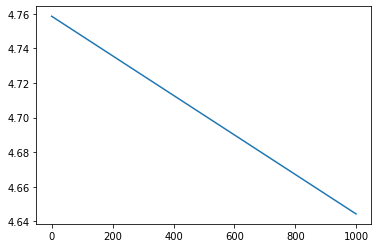

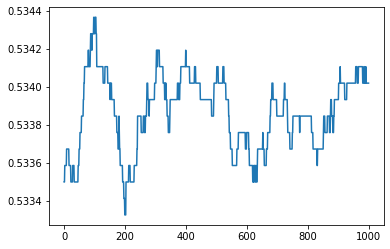

In [79]:
from matplotlib import pyplot as plt
print(len(main_loss))
# loss
plt.plot(main_loss)
plt.show()
# accuracy
plt.plot(main_loss_1)
plt.show()

We have got 53.4 percent class accuracy while implementing Homegrown logistic regression. We have used our homework class notebook code to implement homegrown logistic and linear regression. For cxe_mxe we have done 1000 epochs and at 1000th epoch we got cxe+mse as 31.49, cxe as 4.7, and mse as 26.791.

# Multilayer perceptron 

## preprocess

In [81]:
from collections import Counter
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
import tarfile
from tqdm.notebook import tqdm
import warnings

In [83]:
def extract_tar(file, path):
    """
    function to extract tar.gz files to specified location
    
    Args:
        file (str): path where the file is located
        path (str): path where you want to extract
    """
    with tarfile.open(file) as tar:
        files_extracted = 0
        for member in tqdm(tar.getmembers()):
            if os.path.isfile(path + member.name[1:]):
                continue
            else:
                tar.extract(member, path)
                files_extracted += 1
        tar.close()
        if files_extracted < 3:
            print('Files already exist')

In [84]:
extract_path = 'images/'
image_file_name = 'cadod.tar.gz'
bounding_box_file_name = 'cadod.csv'


image_path = os.path.join(DATA_DIR, image_file_name)
bounding_box_path = os.path.join(DATA_DIR, bounding_box_file_name)
resize_path = os.path.join(extract_path, "resized")

In [85]:
!mkdir -p $resize_path

In [86]:
extract_tar(image_path, extract_path)

  0%|          | 0/25936 [00:00<?, ?it/s]

Files already exist


In [87]:
df = pd.read_csv(bounding_box_path)

In [88]:
df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000b9fcba019d36,xclick,/m/0bt9lr,1,0.165000,0.903750,0.268333,0.998333,1,1,...,0,0,0.636250,0.903750,0.748750,0.165000,0.268333,0.506667,0.998333,0.661667
1,0000cb13febe0138,xclick,/m/0bt9lr,1,0.000000,0.651875,0.000000,0.999062,1,1,...,0,0,0.312500,0.000000,0.317500,0.651875,0.000000,0.410882,0.999062,0.999062
2,0005a9520eb22c19,xclick,/m/0bt9lr,1,0.094167,0.611667,0.055626,0.998736,1,1,...,0,0,0.487500,0.611667,0.243333,0.094167,0.055626,0.226296,0.998736,0.305942
3,0006303f02219b07,xclick,/m/0bt9lr,1,0.000000,0.999219,0.000000,0.998824,1,1,...,0,0,0.508594,0.999219,0.000000,0.478906,0.000000,0.375294,0.720000,0.998824
4,00064d23bf997652,xclick,/m/0bt9lr,1,0.240938,0.906183,0.000000,0.694286,0,0,...,0,0,0.678038,0.906183,0.240938,0.522388,0.000000,0.370000,0.424286,0.694286


In [89]:
df.LabelName.unique()

array(['/m/0bt9lr', '/m/01yrx'], dtype=object)

In [90]:
df.LabelName.replace({'/m/01yrx':'cat', '/m/0bt9lr':'dog'}, inplace=True)

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [92]:
from sklearn.model_selection import train_test_split


In [93]:
df.shape[0]

12966

In [94]:
#Getting and resizing images
images = np.zeros((df.shape[0],32*32*3)) 
for i, id in enumerate(tqdm(df.ImageID)):
    img = Image.open(extract_path+id+'.jpg')
    images[i] = np.asarray(img.resize((32,32))).flatten()

  0%|          | 0/12966 [00:00<?, ?it/s]

In [95]:
#Normalization
mean=[]
std=[]
for i in range(len(images)):
  mean.append(np.array(images[i], dtype=np.uint8).flatten().mean()/255)
  std.append(np.array(images[i], dtype=np.uint8).flatten().std()/255)


images_tensor = [np.round((((images[i]/255)-mean[i])/std[i]),5).astype(np.float32) for i in range(len(images))]


In [96]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [97]:
df['type'] = df['LabelName'].map( {'dog': 1, 'cat': 0})

In [98]:
labels = df['type'].to_numpy()

In [99]:
X_train, X_test, y_train, y_test = train_test_split(images_tensor, labels, test_size=0.33,random_state=25)

In [100]:
y_train.shape

(8687,)

In [101]:
train_loader = torch.utils.data.DataLoader([ [X_train[i], y_train[i]] for i in range(len(y_train))],shuffle = True, batch_size = 300)

test_loader = torch.utils.data.DataLoader([ [X_test[i], y_test[i]] for i in range(len(y_test))],shuffle = True, batch_size = 300)


## Classification using multilayer perceptron

In [102]:
class classifier(nn.Module):
    def __init__(self):
        super().__init__()        
        self.input_layer = nn.Linear(32 * 32 *3, 250)
        self.hidden_layer = nn.Linear(250, 100)
        self.output_layer = nn.Linear(100, 2)
       
    def forward(self, x):                       
        x = self.input_layer(x)
        x = F.relu(x)     
        x = self.hidden_layer(x)
        x = F.relu(x)     
        x = self.output_layer(x)
        return x

In [103]:
model = classifier().to(device)

In [104]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [105]:

def train(net, device, trainSet,testSet, optimizer,epoch,criterion):
    totalLoss=0
    correct=0
    for x,y in trainSet:
      x = x.to(device)
      y = y.to(device)
      pred = net(x)
      loss = criterion(pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      totalLoss+=loss.item()
      predictedLabels = pred.argmax(dim=1)
      correct += predictedLabels.eq(y.view_as(predictedLabels)).sum().item()

    print(f"\nEpoch: {epoch+1}  Train Average Loss: {(totalLoss/(len(trainSet.dataset)/300)):.4f}  Train Accuracy: {correct}/{len(trainSet.dataset)} ({100. * correct / len(trainSet.dataset):.2f}%)")
    correct=0
    with torch.no_grad():
      for x_test,y_test in testSet:
          x_test = x_test.to(device)
          y_test = y_test.to(device)
          pred = net(x_test)
          predictedLabels = pred.argmax(dim=1)
          correct += predictedLabels.eq(y_test.view_as(predictedLabels)).sum().item()
          testAccuracy=100. * correct / len(testSet.dataset)
      print(f"\nEpoch: {epoch+1}  Validation Accuracy: {correct}/{len(testSet.dataset)} ({testAccuracy:.2f}%)")

In [106]:
epochs=30
for epoch in range(epochs):
  train(model,device,train_loader,test_loader,optimizer,epoch,criterion)


Epoch: 1  Train Average Loss: 0.6898  Train Accuracy: 4787/8687 (55.11%)

Epoch: 1  Validation Accuracy: 2441/4279 (57.05%)

Epoch: 2  Train Average Loss: 0.6517  Train Accuracy: 5331/8687 (61.37%)

Epoch: 2  Validation Accuracy: 2425/4279 (56.67%)

Epoch: 3  Train Average Loss: 0.6178  Train Accuracy: 5697/8687 (65.58%)

Epoch: 3  Validation Accuracy: 2478/4279 (57.91%)

Epoch: 4  Train Average Loss: 0.5714  Train Accuracy: 6139/8687 (70.67%)

Epoch: 4  Validation Accuracy: 2405/4279 (56.20%)

Epoch: 5  Train Average Loss: 0.5213  Train Accuracy: 6494/8687 (74.76%)

Epoch: 5  Validation Accuracy: 2372/4279 (55.43%)

Epoch: 6  Train Average Loss: 0.4514  Train Accuracy: 6898/8687 (79.41%)

Epoch: 6  Validation Accuracy: 2420/4279 (56.56%)

Epoch: 7  Train Average Loss: 0.3743  Train Accuracy: 7304/8687 (84.08%)

Epoch: 7  Validation Accuracy: 2436/4279 (56.93%)

Epoch: 8  Train Average Loss: 0.2977  Train Accuracy: 7671/8687 (88.30%)

Epoch: 8  Validation Accuracy: 2404/4279 (56.18%)


In [107]:
model.parameters

<bound method Module.parameters of classifier(
  (input_layer): Linear(in_features=3072, out_features=250, bias=True)
  (hidden_layer): Linear(in_features=250, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=2, bias=True)
)>

In [108]:
with torch.no_grad():
    correct=0
    total_loss=0
    for x_test,y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        pred = model(x_test)
        test_loss = criterion(pred, y_test)
        predictedLabels = pred.argmax(dim=1)
        correct += predictedLabels.eq(y_test.view_as(predictedLabels)).sum().item()
        total_loss+=test_loss.item()
    testAccuracy=100. * correct / len(test_loader.dataset)
    total_loss = total_loss/(len(test_loader.dataset)/300)

In [109]:
results = pd.DataFrame(columns=["Model_name","Test_Accuracy","Test_Loss"])

In [110]:
results.loc[0,:10]  = [f"Classification using multilayer perceptron"]+list([np.round(testAccuracy,3),np.round(total_loss,3)])


In [111]:
results

,Model_name,Test_Accuracy,Test_Loss
0,Classification using multilayer perceptron,56.602,2.357


## Regression using MLP

In [112]:
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()        
        self.input_layer = nn.Linear(32 * 32 *3, 250)
        self.hidden_layer = nn.Linear(250, 100)
        self.output_layer = nn.Linear(100, 4)
       
    def forward(self, x):                       
        x = self.input_layer(x)
        x = F.relu(x)     
        x = self.hidden_layer(x)
        x = F.relu(x)     
        x = self.output_layer(x)
        return x

In [113]:
df.columns

Index(['ImageID', 'Source', 'LabelName', 'Confidence', 'XMin', 'XMax', 'YMin',
       'YMax', 'IsOccluded', 'IsTruncated', 'IsGroupOf', 'IsDepiction',
       'IsInside', 'XClick1X', 'XClick2X', 'XClick3X', 'XClick4X', 'XClick1Y',
       'XClick2Y', 'XClick3Y', 'XClick4Y', 'type'],
      dtype='object')

In [114]:
lables_box= df[['XMin', 'YMin', 'XMax', 'YMax']].to_numpy(dtype ='float32')

In [115]:
#Custom dataset for binding box labels
class data(torch.utils.data.Dataset):
  def __init__(self, X, y, scale_data=True):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

In [116]:
lables_box.shape

(12966, 4)

In [117]:
# using first 10000 images for train and rest for test out of 12966 images
train_dataSet= data(np.array(images_tensor[:10000]), np.array(lables_box[:10000]))
test_dataSet= data(np.array(images_tensor[10000:]), np.array(lables_box[10000:]))

In [118]:
train_loader_new = torch.utils.data.DataLoader(train_dataSet, batch_size=300, shuffle=True, num_workers=1)
test_loader_new = torch.utils.data.DataLoader(test_dataSet, batch_size=300, shuffle=True, num_workers=1)


In [119]:
model2= RegressionModel().to(device)

In [120]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4)

In [121]:
def train_reg(net,device,trainSet,optimizer,epoch,criterion):
    totalLoss=0
    for x,y in trainSet:
      x = x.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      loss=0
      for i in range(len(x)):
        pred=net(x[i].flatten())
        loss += criterion(pred, y[i])/ len(x)
      loss.backward()
      optimizer.step()
      totalLoss+=loss.item()
    print(f"\nEpoch: {epoch+1}  Train Average Loss: {(totalLoss/(len(trainSet.dataset)/300)):.4f}")



In [122]:
epochs=20
for epoch in range(epochs):
  train_reg(model2,device,train_loader_new,optimizer,epoch,criterion)


Epoch: 1  Train Average Loss: 0.2425

Epoch: 2  Train Average Loss: 0.1184

Epoch: 3  Train Average Loss: 0.0962

Epoch: 4  Train Average Loss: 0.0856

Epoch: 5  Train Average Loss: 0.0784

Epoch: 6  Train Average Loss: 0.0731

Epoch: 7  Train Average Loss: 0.0692

Epoch: 8  Train Average Loss: 0.0660

Epoch: 9  Train Average Loss: 0.0631

Epoch: 10  Train Average Loss: 0.0606

Epoch: 11  Train Average Loss: 0.0588

Epoch: 12  Train Average Loss: 0.0564

Epoch: 13  Train Average Loss: 0.0551

Epoch: 14  Train Average Loss: 0.0530

Epoch: 15  Train Average Loss: 0.0515

Epoch: 16  Train Average Loss: 0.0507

Epoch: 17  Train Average Loss: 0.0493

Epoch: 18  Train Average Loss: 0.0478

Epoch: 19  Train Average Loss: 0.0465

Epoch: 20  Train Average Loss: 0.0457


In [123]:
with torch.no_grad():
  totalLoss=0
  for x,y in test_loader_new:
      x = x.to(device)
      y = y.to(device)
      loss=0
      for i in range(len(x)):
        pred=model2(x[i].flatten())
        loss += criterion(pred, y[i])/ len(x)
      totalLoss+=loss.item()
  totalLoss = totalLoss/(len(test_loader_new.dataset)/300)



In [124]:
results.loc[1,:10]  = [f"Regression using multilayer perceptron"]+list(["-",np.round(totalLoss,3)])

In [125]:
results

,Model_name,Test_Accuracy,Test_Loss
0,Classification using multilayer perceptron,56.602,2.357
1,Regression using multilayer perceptron,-,0.081


## Multi Head

In [126]:
#Custom dataset for multihead
class data_mh(torch.utils.data.Dataset):
  def __init__(self, X, y1,y2, scale_data=True):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      self.X = torch.from_numpy(X)
      self.y1 = torch.from_numpy(y)
      self.y2 = torch.from_numpy(y)


  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], {'label_c':self.y1[i],'label_r': self.y2[i]}

In [127]:
# using first 10000 images for train and rest for test out of 12966 images
train_dataSet= data_mh(np.array(images_tensor[:10000]), np.array(labels[:10000]), np.array(lables_box[:10000]))
test_dataSet= data_mh(np.array(images_tensor[10000:]),  np.array(labels[10000:]), np.array(lables_box[10000:]))

In [128]:
len(images_tensor)

12966

In [129]:
len(labels)

12966

In [130]:
len(lables_box)

12966

In [131]:
train_loader_mh = torch.utils.data.DataLoader([ [images_tensor[i], labels[i],lables_box[i]] for i in range(10000)], batch_size=300, shuffle=True, num_workers=1)
test_loader_mh = torch.utils.data.DataLoader([ [images_tensor[i], labels[i],lables_box[i]] for i in range(10000,len(labels))], batch_size=300, shuffle=True, num_workers=1)


In [132]:
class Multihead(nn.Module):
    def __init__(self):
        super().__init__()           
        self.input_layer = nn.Linear(32 * 32 *3, 250)
        self.hidden_layer = nn.Linear(250, 100)
        self.output_layer_classifcation = nn.Linear(100, 2)
        self.output_layer_regression = nn.Linear(100, 4)
    
    def forward(self, x):        
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_layer(x))
        out_classifcation=self.output_layer_classifcation(x)
        out_regression=self.output_layer_regression(x)

        return out_classifcation,out_regression, x

In [133]:
criterion_c = nn.CrossEntropyLoss()
criterion_r = nn.MSELoss()


In [134]:
model_mh = Multihead().to(device)
optimizer = optim.Adam(model_mh.parameters())

In [135]:

def train_mh(net, device, trainSet,testSet, optimizer,epoch):
    totalLoss=0
    correct=0
    for x,y_c,y_r in trainSet:
      x = x.to(device)
      y_c = y_c.to(device)
      y_r = y_r.to(device)

      pred_c,pred_r,_ = net(x)
      loss_c = criterion_c(pred_c, y_c)
      loss_r = criterion_r(pred_r, y_r)
      loss = loss_c+loss_r
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      totalLoss+=loss.item()
      predictedLabels = pred_c.argmax(dim=1)
      correct += predictedLabels.eq(y_c.view_as(predictedLabels)).sum().item()

    print(f"\nEpoch: {epoch+1}  Train Loss: {(totalLoss/(len(trainSet.dataset)/300)):.4f}  Train Accuracy for classification: {correct}/{len(trainSet.dataset)} ({100. * correct / len(trainSet.dataset):.2f}%)")
    correct=0
    with torch.no_grad():
      total_test_loss = 0
      for x_test,y_test_c,y_test_r in testSet:
          x_test = x_test.to(device)
          y_test_c = y_test_c.to(device)
          y_test_r = y_test_r.to(device)
          pred_c,pred_r,_ =  net(x_test)
          loss_c = criterion_c(pred_c, y_test_c)
          loss_r = criterion_r(pred_r, y_test_r)
          test_loss=loss_c+loss_r
          total_test_loss+=test_loss.item()
          predictedLabels = pred_c.argmax(dim=1)
          correct += predictedLabels.eq(y_test_c.view_as(predictedLabels)).sum().item()
          testAccuracy=100. * correct / len(testSet.dataset)
      print(f"\nEpoch: {epoch+1}  Validation Loss: {(total_test_loss/(len(testSet.dataset)/300)):.4f} Validation Accuracy for classification: {correct}/{len(testSet.dataset)} ({testAccuracy:.2f}%)")

In [136]:
epochs=20
for epoch in range(epochs):
  train_mh(model_mh,device,train_loader_mh,test_loader_mh,optimizer,epoch)


Epoch: 1  Train Loss: 0.6938  Train Accuracy for classification: 6652/10000 (66.52%)

Epoch: 1  Validation Loss: 1.1822 Validation Accuracy for classification: 221/2966 (7.45%)

Epoch: 2  Train Loss: 0.6206  Train Accuracy for classification: 6952/10000 (69.52%)

Epoch: 2  Validation Loss: 1.2562 Validation Accuracy for classification: 196/2966 (6.61%)

Epoch: 3  Train Loss: 0.5943  Train Accuracy for classification: 7092/10000 (70.92%)

Epoch: 3  Validation Loss: 1.0795 Validation Accuracy for classification: 798/2966 (26.90%)

Epoch: 4  Train Loss: 0.5566  Train Accuracy for classification: 7375/10000 (73.75%)

Epoch: 4  Validation Loss: 1.2469 Validation Accuracy for classification: 583/2966 (19.66%)

Epoch: 5  Train Loss: 0.5071  Train Accuracy for classification: 7708/10000 (77.08%)

Epoch: 5  Validation Loss: 1.1461 Validation Accuracy for classification: 930/2966 (31.36%)

Epoch: 6  Train Loss: 0.4713  Train Accuracy for classification: 7897/10000 (78.97%)

Epoch: 6  Validation

In [137]:
with torch.no_grad():
      total_test_loss = 0
      correct=0
      for x_test,y_test_c,y_test_r in test_loader_mh:
          x_test = x_test.to(device)
          y_test_c = y_test_c.to(device)
          y_test_r = y_test_r.to(device)
          pred_c,pred_r,_ =  model_mh(x_test)
          loss_c = criterion_c(pred_c, y_test_c)
          loss_r = criterion_r(pred_r, y_test_r)
          test_loss=loss_c+loss_r
          total_test_loss+=test_loss.item()
          predictedLabels = pred_c.argmax(dim=1)
          correct += predictedLabels.eq(y_test_c.view_as(predictedLabels)).sum().item()
      testAccuracy=100. * correct / len(test_loader_mh.dataset)
      test_loss= total_test_loss/(len(test_loader_mh.dataset)/300)
      print(f"Test Loss: {test_loss:.4f} Test Accuracy for classification: {correct}/{len(test_loader_mh.dataset)} ({testAccuracy:.2f}%)")

Test Loss: 3.6849 Test Accuracy for classification: 1076/2966 (36.28%)


In [138]:
results.loc[2,:10]  = [f"Multi Head "]+list([np.round(testAccuracy,2),np.round(test_loss,3)])

In [139]:
results

,Model_name,Test_Accuracy,Test_Loss
0,Classification using multilayer perceptron,56.602,2.357
1,Regression using multilayer perceptron,-,0.081
2,Multi Head,36.28,3.685


**Results**

In above phase1 we got highest accuracy for stochastic gradient which is 57 percent. In phase2 using Homegrown logistic and linear regression we got a class accuracy of 53 percent which is not bad and using classification with Multilayer perceptron we got 56 percent which created wonders. Multi Head API did not worked well for this classification. We have also used relu and leakyrelu but even this did not worked well. In Home grown Linear regression we obtained a loss of 27. In Home grown logistic regression we obtained a loss of 31.43 using CXE+MSE

**Challenges**

In Home grown we faced issues of resusing the code so many times but using same objects in the class are so confusing and so many errors arised.


**Conclusion**

We focused on the SKLearn Baseline models for Logistic Regression, SGDClassifier to classify the images into cats and dogs, and Linear Regression to mark the bounding boxes around the cats and dogs inside the image in phase 1. 
We have also implemented the Homegrown Logistic Regression and Homegrown Linear Regression to compare the results. 
The homegrown implementation of logistic regression to do both classification and regression. 
In addition, we devised MLPs for classification and regression without dropout, using PyTorch's Sequential and OOP APIs.
The number of hidden layers, drop out, learning rate, number of epochs, and other variables were all tested, and the results were tabulated.